# Homework
## Preparing the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

In [3]:
df = pd.read_csv(url)

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical = list(df.select_dtypes(exclude='number'))
numerical = list(df.select_dtypes('number'))

numerical.remove('converted')

print(categorical)
print(numerical)

for c in categorical:
    df[c] = df[c].str.lower().str.replace(' ', '_').fillna('NA')

for c in numerical:
	df[c] = df[c].fillna(0.0)

['lead_source', 'industry', 'employment_status', 'location']
['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [4]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

df_train.drop('converted', axis=1, inplace=True)
df_val.drop('converted', axis=1, inplace=True)
df_test.drop('converted', axis=1, inplace=True)

In [6]:
for col in numerical:
	y_pred = df_train[col]
	print(col, round(roc_auc_score(y_train, y_pred), 3))

number_of_courses_viewed 0.764
annual_income 0.552
interaction_count 0.738
lead_score 0.614


## Model Training

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [9]:
print(round(roc_auc_score(y_val, y_pred), 3))

0.817


In [10]:
thresholds = np.linspace(0, 1, 101)

recall_scores = []
precision_scores = []
f1_scores = {}

for t in thresholds:
	precision = precision_score(y_val, y_pred >= t, zero_division=0.0)
	recall = recall_score(y_val, y_pred >= t, zero_division=0.0)
	f1 = f1_score(y_val, y_pred >= t, zero_division=0.0)

	recall_scores.append(recall)
	precision_scores.append(precision)
	f1_scores[t] = f1

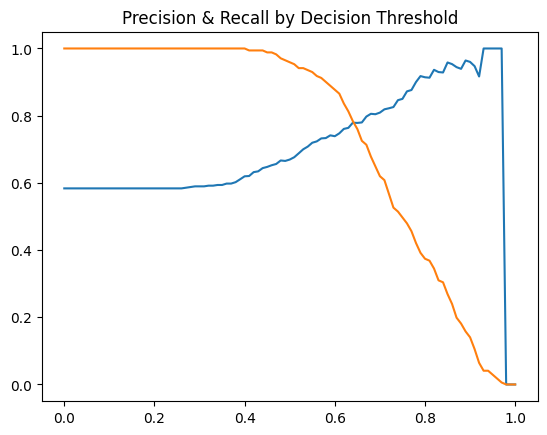

In [11]:
plt.plot(thresholds, precision_scores)
plt.plot(thresholds, recall_scores)
plt.title('Precision & Recall by Decision Threshold')
plt.show()

In [12]:
f1_scores[0.14], f1_scores[0.34], f1_scores[0.54], f1_scores[0.74]

(0.7370689655172413, 0.7450980392156863, 0.8060453400503779, 0.64)

In [13]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [14]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [15]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [16]:
np.std(scores)

0.03580711942905165

In [17]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036
